# Razor Test CSX Summary
Measuring thermal expansion / contraction of cryostat with LHe cooling at a typical flow rate

**Experimental SETUP:**
* Simulate x-rays with low power laser 
* User fine edge razor blade to make knife edge scans
* Scan razor transvere to beam

**NOTE TO UM2022 WS6 AUDIENCE:**
*This notebook is designed to show legacy code and represent documentation that is possible*
- This notebook requires with databroker v1 and will not work in the UM2022 Workshop 6. 
- This notebook currently is supported on jupyter.nsls2.
- This notebook can easily be altered to work with tiled and the data here in is found in:
    ```python
    from tiled.client import from_uri
    c = from_uri("https://tiled-demo.blueskyproject.io/api")
    csx = c["csx"]["raw"]
    ```

In [1]:
from databroker import Broker
db = Broker.named("csx")

from matplotlib import pyplot as plt, patches as patches

import pandas as pd
pd.options.display.max_rows = None 

OBJECT CACHE: Will use up to 121_499_070_873 bytes (15% of total physical RAM)


In [2]:
df = pd.read_csv("CSX_2021_12_17.csv")

In [3]:
%matplotlib widget

In [4]:
%matplotlib inline

In [5]:
laser_lsat = db[154703]
laser_half_cut = db[154704]
dif_beam_image_rois_positions = db[154697]

In [6]:
# print('^+x\n|')
# print('|\n'*3, end='')
# print('|-x')

## Laser beam profile on LSAT crystal
- just seeing size and shape of laser with sample in the approximate center of rotation in the diffractometer

Text(-2, 0, 'Sample Directions')

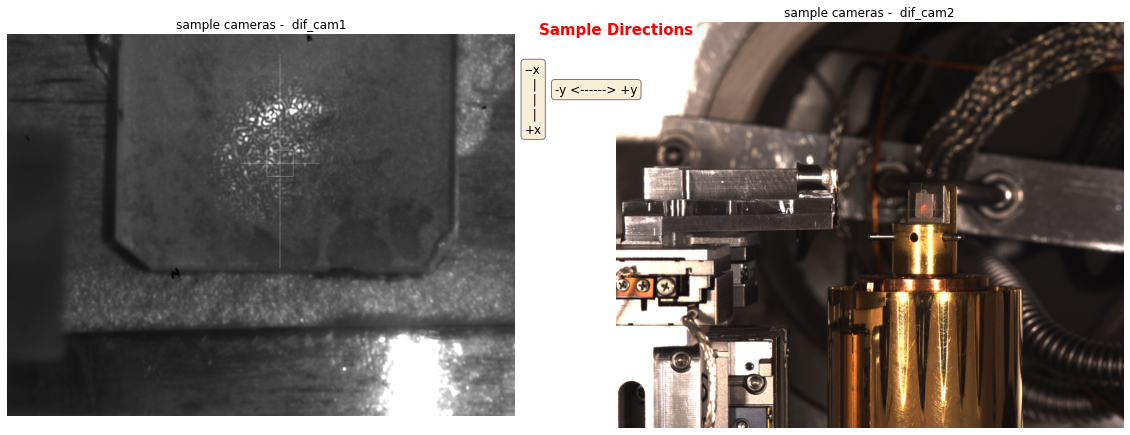

In [7]:
header = laser_lsat
detectors = header.start["detectors"]

fig, axes = plt.subplots(1, len(detectors), figsize=(20, 10))
for i, detector in enumerate(detectors):
    ax = axes[i]
    img = next(header.data(detector+"_image"))
    ax.set(title=f'{header.start["purpose"]} -  {detector}')
    ax.imshow(img[0], cmap='gray')
    ax.axis("off")
    
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
textstr = '--x\n'+'  |\n'*3+'+x'
ax.text(-0.18, 0.90, textstr, transform=ax.transAxes, fontsize=12,
    verticalalignment='top', bbox=props)
textstr = '-y <'+'--'*3+'> +y'
ax.text(-0.12, 0.85, textstr, transform=ax.transAxes, fontsize=12,
    verticalalignment='top', bbox=props)
ax.text(-2, 0, "Sample Directions", fontsize=15,verticalalignment='top', horizontalalignment='center', c='r', weight='bold')


## Razor fully in
- increasing x direction scan will put beam on the detector (dif_beam)
- sample slightly rotated to see laser beam ; razor surface normal is parallel to beam for the test


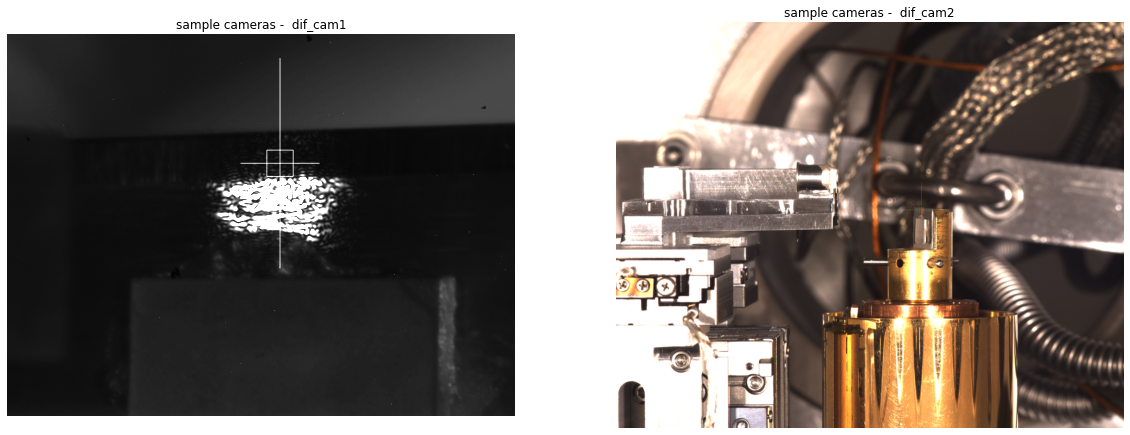

In [8]:
header = laser_half_cut
detectors = header.start["detectors"]

fig, axes = plt.subplots(1, len(detectors), figsize=(20, 10))
for i, detector in enumerate(detectors):
    ax = axes[i]
    img = next(header.data(detector+"_image"))
    ax.set(title=f'{header.start["purpose"]} -  {detector}')
    if i == 0:
        ax.imshow(img[0], cmap='gray', vmax=80)
    else:
        
        ax.imshow(img[0], cmap='gray')
    ax.axis("off")

## Laser beam on detector screen
- razor retracted in the vacuum chamber

Exposure time 1.0

Detector stats calculated on ROIs
	ROI 1 - Hstart= 678 , Vstart= 674 , w
	ROI 2 - Hstart= 696 , Vstart= 788 , deepskyblue
	ROI 3 - Hstart= 631 , Vstart= 739 , limegreen
	ROI 4 - Hstart= 250 , Vstart=1455 , w


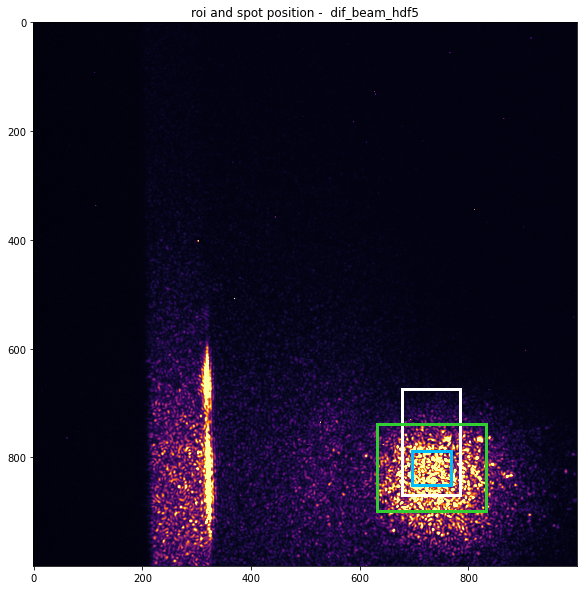

In [9]:
header = dif_beam_image_rois_positions
detector = header.start["detectors"][0]

fig, ax = plt.subplots(figsize=(10,10))
img = next(header.data(detector+"_image"))
ax.set(title=f'{header.start["purpose"]} -  {detector}')
ax.imshow(img[0,0:1000, 0:1000], cmap='inferno', vmax=2000)

config = header.descriptors[0]["configuration"][detector]["data"]
print(f'Exposure time {config[detector+"_cam_acquire_time"]}\n')

print('Detector stats calculated on ROIs')
for roi_n, color in zip([str(x) for x in range(1,5)], ['w', 'deepskyblue', 'limegreen','w']):
    Hpix,Vpix =    (config[f'{detector}_roi{roi_n}_min_xyz_min_{p_dir}'] for p_dir in ["x","y"])
    Hsize, Vsize = (config[f'{detector}_roi{roi_n}_size_{p_dir}']        for p_dir in ["x","y"])
    
    print(f'\tROI {roi_n} - Hstart={Hpix:^5}, Vstart={Vpix:^5}, {color}')
    
    rect = patches.Rectangle((Hpix, Vpix), Hsize, Vsize, linewidth=3, edgecolor=color, facecolor='none')
    ax.add_patch(rect)

### Plans, screpts and definitions are centrally saved

- Access via jupyter.nsls2 after your experiments
- Data collected using python file `cryo_exp_laser_razor.py` and entering `RE(all_Ts())` in bluessky

**`bluesky bash terminal`**
```python
%run -i cryo_exp_laser_razor.py
print_summary(all_Ts)  # make sure python script is interpretted by bluesky
check_limits(all_Ts)  # ensure no motor limits are exceed (for absolute moves only)

RE(all_Ts()) # start data acquisition
```

**`cryo_exp_laser_razor.py`**
```python
RE.md['sample']={'type': 'laser_cryo_exp','composition':'razor'}

def get_centered(Tdir):
    if Tdir == 'up':
        uid = yield from rel_scan([dif_beam],sx, -1, 1.25, 13, md={'purpose':'intial sx center'})
    if Tdir == 'down':
        uid = yield from rel_scan([dif_beam],sx, -1.25, 1.0, 13, md={'purpose':'intial sx center'})
    if uid is None:
        pass
    else:
        yield from bps.sleep(5)
        new_sx = peaks.cen["dif_beam_stats3_total"]
        yield from mv(sx, new_sx)
    uid = yield from rel_scan([dif_beam],sx, -0.75, 0.75, 31, md={'purpose':'rough sx center'})
    if uid is None:
        pass
    else:
        yield from bps.sleep(5)
        new_sx = peaks.cen["dif_beam_stats3_total"]
        yield from mv(sx, new_sx)

def wait_Tequil(Ttarget, Tdelta=0.05, loops = 3):
    for _ in range(2):
        Tnow = stemp.temp.B.T.get()
        print(f'Waiting for T to be within {Tdelta:.3f}K for {Ttarget:.3f}K')
        while abs(Tnow-Ttarget) >Tdelta:
            yield from bps.sleep(30)
            Tnow = stemp.temp.B.T.get()
        yield from bps.sleep(2*60)
        Tdelta = Tdelta/2

def do_one_T(Ttarget, Tdir, Tdelta=0.5, loops=2):
    yield from wait_Tequil(Ttarget,Tdelta)
    yield from get_centered(Tdir)
    for i in range(loops):
        print(f'Starting {i} of 0-{loops}')
        yield from count([dif_beam, stemp.temp.B.T], num = int(60*5), delay =0.5)
        yield from rel_scan([dif_beam, stemp.temp.B.T],sx, -0.75, 0.75, 41, md={'purpose':f'sx center 1 T'})


def all_Ts():
    Temps = [331.5-x - 15*3 for x in range(0, 290- 15*3, 15)]
    for Temp in Temps:
        yield from mv(stemp.ctrl1.setpoint, Temp)
        yield from do_one_T(Temp, Tdelta=0.2, loops = 3, Tdir = 'down')
```

In [10]:
df

,Unnamed: 0,scan_id,plan_name,motors,detectors,energy[eV],Tsample[K],sx,fccd_aquire_time,fccd_num_images,fccd_image_type,fccd_ct_time,scan_time[min],sample_type,sample_comp,purpose,notes
0,0,150959,rel_scan,['sz'],['dif_beam'],709.0,30.17,9.50,-,-,-,-,1.6,laser cryo exp,razor,na,NaN
1,1,150960,rel_scan,['sz'],['dif_beam'],709.0,30.22,9.50,-,-,-,-,4.6,laser cryo exp,razor,na,NaN
2,2,150961,rel_scan,['sx'],['dif_beam'],709.0,31.05,10.00,-,-,-,-,8.6,laser cryo exp,razor,na,NaN
3,3,150962,rel_scan,['sx'],['dif_beam'],709.0,30.81,10.14,-,-,-,-,6.1,laser cryo exp,razor,na,NaN
4,4,150963,rel_scan,['sx'],['dif_beam'],709.0,30.00,10.45,-,-,-,-,9.1,laser_cryo_exp,razor,intial sx center,NaN
5,5,150964,rel_scan,['sx'],['dif_beam'],709.0,30.00,10.19,-,-,-,-,7.4,laser_cryo_exp,razor,rough sx center,NaN
6,6,150965,count,NaN,"['dif_beam', 'stemp_temp_B_T']",709.0,30.00,9.82,-,-,-,-,3.1,laser_cryo_exp,razor,na,NaN
7,7,150966,rel_scan,['sx'],['dif_beam'],709.0,30.00,10.19,-,-,-,-,7.8,laser_cryo_exp,razor,sx center 1 T,NaN
8,8,150967,count,NaN,"['dif_beam', 'stemp_temp_B_T']",709.0,30.00,9.82,-,-,-,-,3.1,laser_cryo_exp,razor,na,NaN
9,9,150968,rel_scan,['sx'],['dif_beam'],709.0,30.00,10.19,-,-,-,-,7.9,laser_cryo_exp,razor,sx center 1 T,NaN
